# Сбор и подготовка данных

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from configs.config import config
from src.data_utils import load_raw_data, prepaire_text, tokenize_texts
from src.next_token_dataset import NextTokenDataset
from src.lstm_model import LSTMModel
from src.eval_lstm import compute_rouge, show_examples
from src.eval_transformer_pipeline import load_transformer_pipeline, evaluate_transformer_rouge, show_transformer_examples
from src.lstm_train import train_epoch

pd.set_option('display.max_colwidth', None)

In [ ]:
# Загрузим параметры
SEQ_LEN = config['SEQ_LEN']
BATCH_SIZE = config['BATCH_SIZE']
TEST_SIZE = config['TEST_SIZE']
VAL_SIZE_FROM_TRAIN = config['VAL_SIZE_FROM_TRAIN']
EMB_DIM = config['EMB_DIM']
HIDDEN_DIM = config['HIDDEN_DIM']
NUM_LAYERS = config['NUM_LAYERS']
DROPOUT = config['DROPOUT']
LR = config['LR']
EPOCHS = config['EPOCHS']
PROMPT_RATIO = config['PROMPT_RATIO']
DEBUG_TRAIN_SIZE = config['DEBUG_TRAIN_SIZE']
DEBUG_VAL_SIZE = config['DEBUG_VAL_SIZE']
DEBUG_TEST_SIZE = config['DEBUG_TEST_SIZE']

In [ ]:
# Читаем сырые данные
filepath = 'data/tweets.txt'
df = load_raw_data(filepath)

print(f"Загружено {len(df)} строк.")
df.head()

Загружено 1600498 строк.


,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
# Очищаем данные
df_clean = prepaire_text(df.copy(), 'text')
print(f"После очистки осталось {len(df_clean)} текстов.")

# Выведем несколько строк
df_clean[['text', 'text_clean']].sample(5)

После очистки осталось 1596919 текстов.


,text,text_clean
1408575,"@Theheartsong Scarves in summer...not a good idea, I agree!","scarves in summer...not a good idea, i agree!"
1501191,"@elise91 oh, i forgot about that, lol thanks. name the triplets Vier, Acht, Drei","oh, i forgot about that, lol thanks. name the triplets vier, acht, drei"
781829,@catheedf Aww you're gonna have to wait til september now too.. but there's something really cool coming up in october as well!,aww you're gonna have to wait til september now too.. but there's something really cool coming up in october as well!
426562,where have the majority of my followings gone???!!! They've dissapeared,where have the majority of my followings gone?! they've dissapeared
774582,cantt findd them eatingg peach yogurt to smooth the pain of my bracelets being gone. wth? haha- THAT WAS LAMEE! lmfao,cantt findd them eatingg peach yogurt to smooth the pain of my bracelets being gone. wth? haha- that was lamee! lmfao


Пунктуация несёт важную информацию о структуре предложения. Если удалить все знаки, текст превратится в поток слов без границ, и модель не научится ставить точки или запятые, что ухудшит качество генерации. Поэтому решено оставить некоторые знаки: . , ! ? : ; " ' ( ) -, а также символы валют ($, €) и десятичные разделители.

Проверим, уменьшилась ли длина текстов за счёт удаления URL, хэштегов, упоминаний и лишних символов.

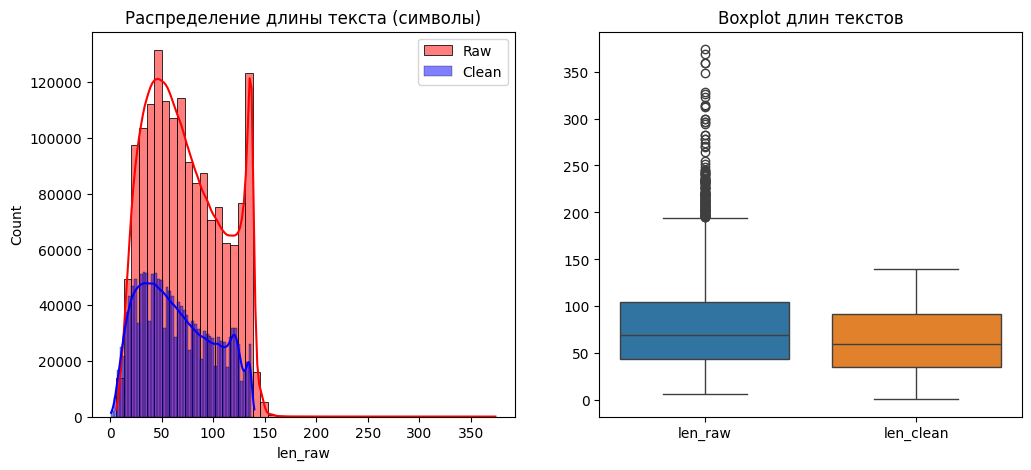

In [ ]:
# Вычисляем длины
df_clean['len_raw'] = df_clean['text'].str.len()
df_clean['len_clean'] = df_clean['text_clean'].str.len()

# Визуализируем результат
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df_clean['len_raw'], bins=50, kde=True, color='red', label='Raw')
sns.histplot(df_clean['len_clean'], bins=50, kde=True, color='blue', label='Clean')
plt.title('Распределение длины текста (символы)')
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(data=df_clean[['len_raw', 'len_clean']])
plt.title('Boxplot длин текстов')
plt.show()

Сдвиг распределения влево и уменьшение "хвостов" говорят об успешном удалении длинных URL и прочего мусора.

In [6]:
# Сохраним очищенные тексты
df_clean.to_csv("data/dataset_processed.csv" , index = False)

In [7]:
# Получаем список очищенных текстов
all_texts = df_clean['text_clean'].tolist()

# Разделение на train/val/test
train_texts, test_texts = train_test_split(all_texts, test_size=TEST_SIZE, random_state=42)
train_texts, val_texts = train_test_split(train_texts, test_size=VAL_SIZE_FROM_TRAIN, random_state=42)

print(f"Train: {len(train_texts)} текстов")
print(f"Val: {len(val_texts)} текстов")
print(f"Test: {len(test_texts)} текстов")

Train: 1293504 текстов
Val: 143723 текстов
Test: 159692 текстов


In [ ]:
# Загружаем токенизатор
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Токенизация
train_tokenized = tokenize_texts(train_texts, tokenizer)
val_tokenized = tokenize_texts(val_texts, tokenizer)
test_tokenized = tokenize_texts(test_texts, tokenizer)

Tokenizing: 100%|██████████| 159692/159692 [00:15<00:00, 10528.97it/s]


In [9]:
# Сохраняем
torch.save(train_tokenized, 'data/train_tokenized.pt')
torch.save(val_tokenized, 'data/val_tokenized.pt')
torch.save(test_tokenized, 'data/test_tokenized.pt')

In [ ]:
# Преобразуем данные в датасеты
train_dataset = NextTokenDataset(train_tokenized, seq_len=SEQ_LEN)
val_dataset = NextTokenDataset(val_tokenized, seq_len=SEQ_LEN)
test_dataset = NextTokenDataset(test_tokenized, seq_len=SEQ_LEN)

print(f"Обучающих примеров: {len(train_dataset)}")
print(f"Валидационных примеров: {len(val_dataset)}")
print(f"Тестовых примеров: {len(test_dataset)}")

Обучающих примеров: 10594894
Валидационных примеров: 1174708
Тестовых примеров: 1306438


In [ ]:
# Загрузим даталоадеры
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Проверка
for x, y in train_loader:
    print(f"Форма входного батча: {x.shape}")
    print(f"Форма целевого батча: {y.shape}")
    break

Форма входного батча: torch.Size([256, 10])
Форма целевого батча: torch.Size([256])


# Реализация рекуррентной сети

In [ ]:
# Определим ресурсы для обработки данных и обучения моделей
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Уменьшаем датасет для отладки
train_dataset_debug = Subset(train_dataset, range(min(DEBUG_TRAIN_SIZE, len(train_dataset))))
debug_train_loader = DataLoader(train_dataset_debug, batch_size=BATCH_SIZE, shuffle=True)

val_texts_debug = val_texts[:min(DEBUG_VAL_SIZE, len(val_texts))]
test_texts_debug = test_texts[:min(DEBUG_TEST_SIZE, len(test_texts))]

Device: cpu


In [ ]:
# Определим модель
model = LSTMModel(
    vocab_size=tokenizer.vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=tokenizer.pad_token_id
).to(device)

# Определим оптимизатор и функцию потерь
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

print(f"Модель создана. Параметров: {sum(p.numel() for p in model.parameters()):,}")

Модель создана. Параметров: 13,446,194


# Тренировка модели

In [14]:
# Списки для истории
train_losses = []
grad_norms = []

best_rouge1 = 0.0

for epoch in range(1, EPOCHS + 1):
    train_loss, grad_norm = train_epoch(model, debug_train_loader, optimizer, criterion, device, return_grad_norm=True)
    train_losses.append(train_loss)
    grad_norms.append(grad_norm)

    val_rouge = compute_rouge(model, val_texts_debug, tokenizer, device, SEQ_LEN, PROMPT_RATIO)
    print(f"Epoch {epoch:2d} | Loss: {train_loss:.4f} | Grad Norm: {grad_norm:.4f} | Val ROUGE: {val_rouge}")

    if val_rouge and val_rouge.get('rouge1', 0) > best_rouge1:
        best_rouge1 = val_rouge['rouge1']
        torch.save(model.state_dict(), 'models/best_lstm_model_debug.pt')
        print(f"Saved best model with ROUGE-1 = {best_rouge1:.4f}")

ROUGE: 100%|██████████| 200/200 [00:02<00:00, 83.87it/s] 


Epoch  1 | Loss: 10.3244 | Grad Norm: 0.1247 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:03<00:00, 61.88it/s]


Epoch  2 | Loss: 10.3114 | Grad Norm: 0.1400 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:03<00:00, 52.78it/s]


Epoch  3 | Loss: 10.2638 | Grad Norm: 0.2757 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:06<00:00, 33.23it/s]


Epoch  4 | Loss: 9.9792 | Grad Norm: 1.1181 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:04<00:00, 43.63it/s]


Epoch  5 | Loss: 8.6779 | Grad Norm: 1.8052 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:02<00:00, 68.27it/s]


Epoch  6 | Loss: 7.3354 | Grad Norm: 1.4245 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:02<00:00, 70.17it/s]


Epoch  7 | Loss: 6.6065 | Grad Norm: 1.3273 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:01<00:00, 107.43it/s]


Epoch  8 | Loss: 6.1363 | Grad Norm: 1.1921 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:01<00:00, 103.90it/s]


Epoch  9 | Loss: 5.8822 | Grad Norm: 1.0296 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


ROUGE: 100%|██████████| 200/200 [00:01<00:00, 105.16it/s]


Epoch 10 | Loss: 5.7724 | Grad Norm: 0.9742 | Val ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


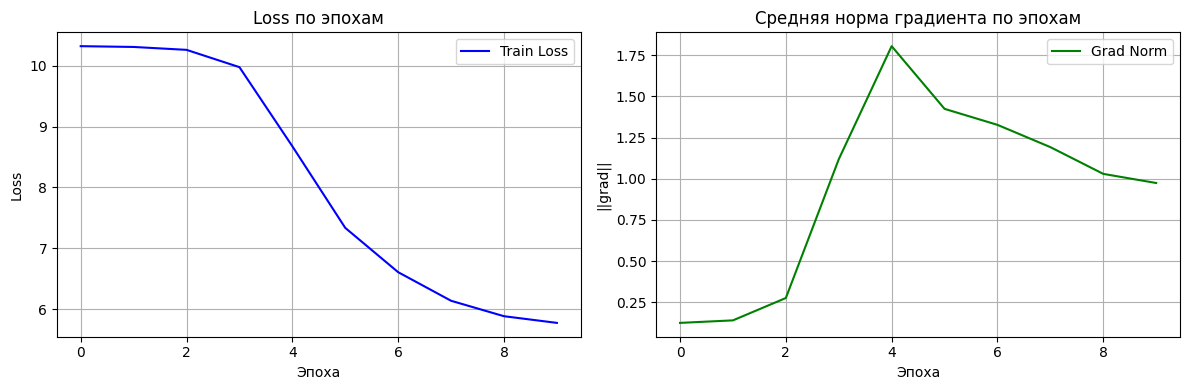

In [21]:
# Визуализируем результат обучения
plt.figure(figsize=(12,4))

# Loss по эпохам
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.title('Loss по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Норма градиента по эпохам
plt.subplot(1,2,2)
plt.plot(grad_norms, label='Grad Norm', color='green')
plt.title('Средняя норма градиента по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('||grad||')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
#model.load_state_dict(torch.load('models/best_lstm_model_debug.pt'))

test_rouge = compute_rouge(model, test_texts_debug, tokenizer, device, SEQ_LEN, PROMPT_RATIO)

print("\nРезультаты LSTM на тесте:")
for k, v in test_rouge.items():
    print(f"{k}: {v:.4f}")

print("\nПримеры генерации LSTM:")
show_examples(model, test_texts_debug, tokenizer, device, SEQ_LEN, num_examples=3, prompt_ratio=PROMPT_RATIO)

ROUGE: 100%|██████████| 200/200 [00:02<00:00, 97.99it/s] 



Результаты LSTM на тесте:
rouge1: 0.0000
rouge2: 0.0000
rougeL: 0.0000
rougeLsum: 0.0000

Примеры генерации LSTM:

Промпт: want some tu
Ожидалось: ##ms?
Сгенерировано: ..

Промпт: and you just got over being sick, right? oh dude, you need your momma to take care of
Ожидалось: you! haha jkjk
Сгенерировано: .......

Промпт: less than 2
Ожидалось: hours
Сгенерировано: .


# Использование предобученного трансформера

In [17]:
# Загружаем pipeline
generator = load_transformer_pipeline(model_name="distilgpt2", device=-1)  # device=-1 для CPU

# Оцениваем на тестовой выборке
transformer_rouge = evaluate_transformer_rouge(generator, test_texts_debug, PROMPT_RATIO)

print("\nМетрики ROUGE на тесте (distilgpt2):")
for k, v in transformer_rouge.items():
    print(f"{k}: {v:.4f}")

print("\nПримеры автодополнений (distilgpt2):")
show_transformer_examples(generator, test_texts_debug, num_examples=5, prompt_ratio=PROMPT_RATIO)

Device set to use cpu
Оценка ROUGE (transformer): 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]



Метрики ROUGE на тесте (distilgpt2):
rouge1: 0.0572
rouge2: 0.0050
rougeL: 0.0586
rougeLsum: 0.0568

Примеры автодополнений (distilgpt2):

Пример 1:
Промпт: can you say exhausted? man, i think i only got 1-2 hours of sleep last nightthis morning. but relay for
Ожидалось:  life was suuuper funnnn.
Сгенерировано:  a while so I figured i could go in

Пример 2:
Промпт: i want a
Ожидалось:  puppy
Сгенерировано:  new

Пример 3:
Промпт: snuggled in with my orange blanky n cuppa camomile tea.. if
Ожидалось:  only my hair would dry by itself
Сгенерировано:  I had to ask you to make

Пример 4:
Промпт: england is back to normal it
Ожидалось: 's raining again
Сгенерировано:  will be much

Пример 5:
Промпт: whoops forgot
Ожидалось:  my
Сгенерировано:  to


# Формулирование выводов

In [18]:
print("Сравнение результатов:")
print(f"LSTM ROUGE-1: {test_rouge.get('rouge1', 0):.4f}")
print(f"Transformer ROUGE-1: {transformer_rouge.get('rouge1', 0):.4f}")

Сравнение результатов:
LSTM ROUGE-1: 0.0000
Transformer ROUGE-1: 0.0572
